In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, lognorm
from scipy.stats import invgamma
from scipy.stats import gamma
import math

We consider the toy dataset $y=\{1,2,3,4\}$

We consider the model of the data to be:
$$
y_i \sim \mathcal{N}(\mu, \sigma^2) \qquad (\text{likelihood}) \\
\mu \sim \mathcal{N}(0, 10) \qquad (\text{prior for } \mu) \\
\sigma^2 \sim \text{Inv-Gamma}(1,1) \qquad (\text{prior for } \sigma^2)
$$

## Task 4.1

In [21]:
mu_ = 5
sigma2 = 5
#y = 4

# log_npdf = lambda x, m, v: -(x-m)**2/(2*v) - 0.5*np.log(2*np.pi*v)

log_npdf = lambda x, m, v: -0.5 * np.log(2 * np.pi * v) - ((x - m) ** 2) / (2 * v)

# log_inv_gamma = lambda x, a, b: a*np.log(b) - np.log(math.gamma(a)) - (a+2)*np.log(x) - b/x

# ! Inv-Gamma(1,1) or (2,1)??
log_inv_gamma = lambda sigma2: -2*np.log(sigma2) - 1/sigma2 # ? analytically determined 

# We can then implement a function for evaluating the log prior, likelihood and posterior
def log_likelihood(x, y, mu, sigma2):
    return np.sum(log_npdf(y, mu, np.sqrt(sigma2)), 0)

# We implement the prior for mu and sigma
def log_prior(x, y, mu, sigma2):
    # Prior for mu: N(0, 10)
    mu_prior = log_npdf(mu, 0, 10)
    
    # Prior for sigma^2: Inv-Gamma(1, 1)
    # sigma2_prior = log_inv_gamma(sigma2)
    sigma2_prior = log_inv_gamma(sigma2)
    
    return mu_prior + sigma2_prior

def log_joint(x, y, mu, sigma2):
    return log_likelihood(x, y, mu, sigma2) + log_prior(x, y, mu, sigma2)

In [22]:
# Toy dataset
y = np.array([1, 2, 3, 4])
x = None


log_prior_values = log_prior(x, y, mu_, sigma2)
log_likelihood_values = log_likelihood(x, y, mu_, sigma2)
log_joint_values = log_joint(x, y, mu_, sigma2)

print("log_prior_values: ", log_prior_values)
print("log_likelihood_values: ", log_likelihood_values)
print("log_joint_values: ", log_joint_values)

log_prior_values:  -6.739106904569896
log_likelihood_values:  -11.993395977752158
log_joint_values:  -18.732502882322052


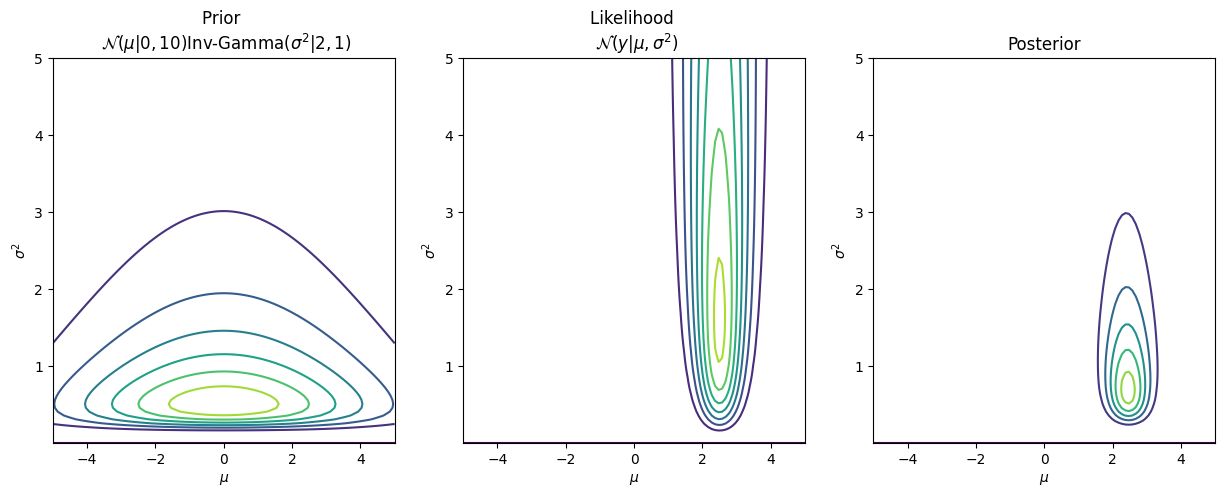

In [24]:
# Try for different values of mu and sigma
# Sample mu and sigma
mu_ = np.linspace(-5, 5, 100)
sigma2_ = np.linspace(1e-6, 5, 100)

# Create grid
mu_grid, sigma2_grid = np.meshgrid(mu_, sigma2_, indexing='ij')

# plot the prior, likelihood and posterior
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
# Prior
ax[0].contour(mu_grid, sigma2_grid, np.exp(log_prior(x, y[:,None,None], mu_grid, sigma2_grid)))
ax[0].set_title('Prior \n $\mathcal{N}(\mu|0,10)\\text{Inv-Gamma}(\sigma^2|2,1)$')
ax[0].set_xlabel('$\mu$')
ax[0].set_ylabel('$\sigma^2$')
# Likelihood

ax[1].contour(mu_grid, sigma2_grid, np.exp(log_likelihood(x, y[:,None,None], mu_grid, sigma2_grid)))
ax[1].set_title('Likelihood \n $\mathcal{N}(y|\mu,\sigma^2)$')
ax[1].set_xlabel('$\mu$')
ax[1].set_ylabel('$\sigma^2$')
# Posterior
ax[2].contour(mu_grid, sigma2_grid, np.exp(log_joint(x, y[:,None,None], mu_grid, sigma2_grid)))
ax[2].set_title('Posterior')
ax[2].set_xlabel('$\mu$')
ax[2].set_ylabel('$\sigma^2$')

# savefig to pdf
plt.savefig('figures/prior_likelihood_posterior.pdf')

plt.show()

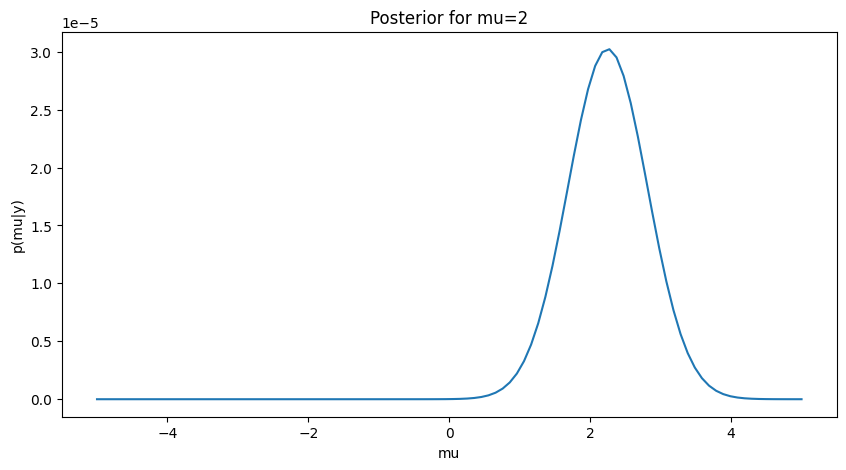

In [19]:
# plot posterior for mu = 2
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(mu_, np.exp(log_joint(x, y[:,None,None], mu_, 2))[0])
ax.set_title('Posterior for mu=2')
ax.set_xlabel('mu')
ax.set_ylabel('p(mu|y)')
plt.show()


## Task 4.2

In [20]:
class GammaNormal(object):

    def __init__(self, x, y, N):
        # data
        self.x = x
        self.y = y
        self.N = N
        print("self.y: ", self.y)

    # We can then implement a function for evaluating the log prior, likelihood and posterior
    def log_likelihood(self, mu, sigma2):
        return np.sum(log_npdf(self.y, mu, np.sqrt(sigma2)), axis=2)

    # We implement the prior for mu and sigma
    def log_prior(self, mu, sigma2):
        # Prior for mu: N(0, 10)
        mu_prior = log_npdf(mu, 0, np.sqrt(10))
        
        # Prior for sigma^2: Inv-Gamma(1, 1)
        # sigma2_prior = log_inv_gamma(sigma2)
        sigma2_prior = log_inv_gamma(sigma2)
        
        return mu_prior + sigma2_prior

    def log_joint(self, mu, sigma2):
        print("123",self.log_likelihood(mu, sigma2).shape)
        print("asdf", self.log_prior(mu, sigma2).shape)
        return self.log_likelihood(mu, sigma2) + self.log_prior(mu, sigma2).squeeze()

In [21]:
model = GammaNormal(x, y, 4)


self.y:  [1 2 3 4]


In [22]:
class Grid2D(object):
    """ helper class for evaluating the function func on the grid defined by (alpha, beta)"""

    def __init__(self, alphas, betas, func, name="Grid2D"):
        self.alphas = alphas
        self.betas = betas
        self.grid_size = (len(self.alphas), len(self.betas))
        self.mu_grid, self.sigma2_grid = np.meshgrid(alphas, betas, indexing='ij')
        self.func = func
        self.name = name
        
        # evaluate function on each grid point
        self.values = self.func(self.mu_grid[:, :, None], self.sigma2_grid[:, :, None]).squeeze()

    def plot_contours(self, ax, color='b', num_contours=10, f=lambda x: x, alpha=1.0, title=None):
        ax.contour(self.alphas, self.betas, f(self.values).T, num_contours, colors=color, alpha=alpha)
        ax.set(xlabel='$\\alpha$', ylabel='$\\beta$')
        ax.set_title(self.name, fontweight='bold')

    @property
    def argmax(self):
        idx = np.argmax(self.values)
        mu_idx, sigma2_idx = np.unravel_index(idx, self.grid_size)
        return self.alphas[mu_idx], self.betas[sigma2_idx]

In [23]:
class GridApproximation2D(Grid2D):

    def __init__(self, alphas, betas, log_joint, threshold=1e-8, name="GridApproximation2D"):
        Grid2D.__init__(self, alphas, betas, log_joint, name)
        self.threshold = threshold
        self.prep_approximation()
        self.compute_marginals()
        self.sanity_check()
        
    def prep_approximation(self):
        
        # [num_alpha, num_beta]-sized matrix of the log joint evaluated on the grid 
        self.log_joint_grid = self.values
        self.log_joint_grid = self.log_joint_grid - np.max(self.log_joint_grid) # These are our unnormalized log probabilities
        # Also called our joing probability distribution. We need to normalize it to get the actual probabilities.)

        # [num_alpha, num_beta]-matrix of \pi_{ij}-values summing to 1.
        self.probabilities_grid = np.exp(self.log_joint_grid) / np.sum(np.exp(self.log_joint_grid))

        # flatten for later convinience
        self.mus_flat = self.mu_grid.flatten()                                             # shape: [num_alpha*num_beta] = [num_outcomes]
        self.sigma2s_flat = self.sigma2_grid.flatten()                                               # shape: [num_alpha*num_beta] = [num_outcomes]
        self.num_outcomes = len(self.mus_flat)                                                # shape: scalar 
        self.probabilities_flat = self.probabilities_grid.flatten()                              # [num_outcomes]

    def compute_marginals(self):
        self.pi_alpha = np.sum(self.probabilities_grid, axis=1) # We marginalise by summing over beta axis which is axis 1
        self.pi_beta =  np.sum(self.probabilities_grid, axis=0)

        # compute marginal distribution using sum rule
    def compute_expectation(self, f):
        """ computes expectation of f(alpha, beta) wrt. the grid approximation """
        return np.sum(f(self.mus_flat, self.sigma2s_flat)*self.probabilities_flat, axis=0)
    
    def sample(self, num_samples=1):
        """ generate num_samples from the grid approximation distribution """
        idx = np.random.choice(np.arange(self.num_outcomes), p=self.probabilities_flat, size=num_samples)
        return self.mus_flat[idx], self.sigma2s_flat[idx]

    def visualize(self, ax, scaling=8000, title='Grid approximation'):
        idx = self.probabilities_flat > self.threshold
        ax.scatter(self.mus_flat[idx], self.sigma2s_flat[idx], scaling*self.probabilities_flat[idx],label='$\pi_{ij}$')        
        # Set y scale to 0-5
        ax.set(xlabel='$\\mu$', ylabel='$\\sigma^2$')
        ax.set_title(title, fontweight='bold')

    def sanity_check(self):
        assert self.probabilities_grid.shape == self.grid_size, "Probability grid does not have shape [num_alphas, num_betas] (self.grid_size). Check your implementation."
        assert np.all(self.probabilities_grid >= 0), "Not all values in probability grid are non-negative. Check your implementation."
        assert np.allclose(self.probabilities_grid.sum(), 1), "Values in probability grid do not sum to one. Check your implementation."


In [24]:
# define grid points (the only reason for using different numbers of points for alpha and beta is to make debugging easier)
num_alpha, num_beta = 90, 100
alphas = np.linspace(-5, 5, num_alpha)
betas = np.linspace(1e-6, 5, num_beta)

In [25]:
log_prior_grid = Grid2D(alphas, betas, model.log_prior, 'Prior')
log_lik_grid = Grid2D(alphas, betas, model.log_likelihood, 'Likelihood')
log_joint_grid = Grid2D(alphas, betas, model.log_joint, 'Posterior')

mu_MLE, sigma2_MLE = log_lik_grid.argmax
mu_MAP, sigma2_MAP = log_joint_grid.argmax

model.log_joint(np.array([[[5]]]),np.array([[[5]]]))

123 (90, 100)
asdf (90, 100, 1)
123 (1, 1)
asdf (1, 1, 1)


array([[-20.85970368]])

123 (90, 100)
asdf (90, 100, 1)


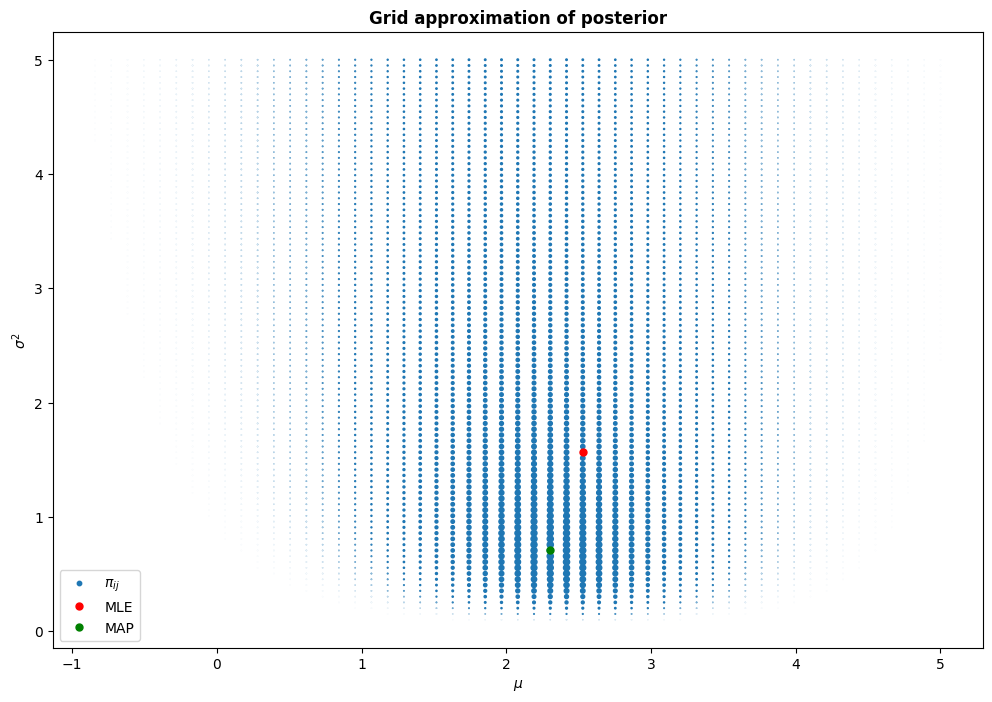

In [26]:
post_approx = GridApproximation2D(alphas, betas, model.log_joint, name='Posterior')

# plot
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
post_approx.visualize(ax, title='Grid approximation of posterior')
ax.plot(mu_MLE, sigma2_MLE, 'r.', label='MLE', markersize=10);
ax.plot(mu_MAP, sigma2_MAP, 'g.', label='MAP', markersize=10);
ax.legend()



## Task 4.3

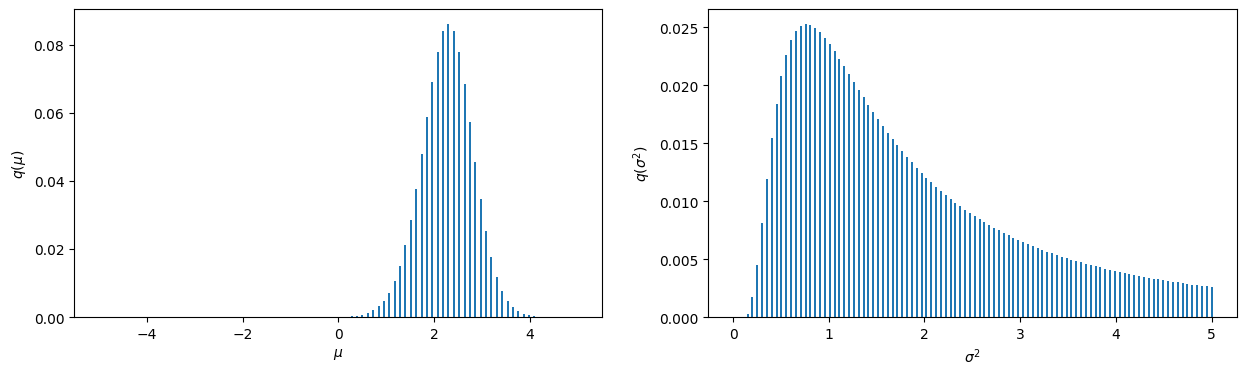

In [43]:
# plot
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
ax[0].bar(post_approx.alphas, post_approx.pi_alpha, width=0.04)
ax[0].set(xlabel='$\\mu$', ylabel='$q(\\mu)$')
ax[1].bar(post_approx.betas, post_approx.pi_beta, width=0.02)
ax[1].set(xlabel='$\\sigma^2$', ylabel='$q(\\sigma^2)$');

In [37]:

class DiscreteDistribution1D(object):

    def __init__(self, outcomes, probabilities, name='DiscreteDistribution'):
        """ represents discrete random variable X in terms of outcomes and probabilities """
        self.outcomes = outcomes
        self.probabilities = probabilities
        assert self.outcomes.shape == self.probabilities.shape
        self.name = name

    def CDF(self, x):
        """ P[X <= x] """
        idx = self.outcomes <= x
        return np.sum(self.probabilities[idx]) 
    
    def quantile(self, p):
        """ Q(p) = inf {x | p < CDF(x)} """
        cdf_values = np.cumsum(self.probabilities) 
        idx = np.where(np.logical_or(p < cdf_values, np.isclose(p, cdf_values)))[0]
        return np.min(self.outcomes[idx])
    
    @property
    def mean(self):
        """ return scalar corresponding to the mean of the discrete distribution """
        x = self.outcomes
        px = self.probabilities
        return np.sum(x * px)
    
    @property
    def variance(self):
        """ return scalar corresponding to the variance of the discrete distribution """
        x = self.outcomes
        px = self.probabilities
        return np.sum((x - self.mean)**2 * px)
    
    def central_interval(self, interval_size=95):
        """ return tuple (lower, upper) corresponding to the central interval of the discrete distribution """
        c = 1.-interval_size/100.
        return self.quantile(c/2), self.quantile(1-c/2)
    
    def print_summary(self):
        print(f'Summary for {self.name}')
        print(f'\tMean:\t\t\t\t{self.mean:3.2f}')
        print(f'\tStd. dev.:\t\t\t{np.sqrt(self.variance):3.2f}')
        print(f'\t95%-credibility interval:\t[{self.central_interval()[0]:3.2f}, {self.central_interval()[1]:3.2f}]\n')

# summarize posterior marginals for alpha and beta
post_alpha_marginal = DiscreteDistribution1D(post_approx.alphas, post_approx.pi_alpha, "posterior distribution of mu")
post_beta_marginal = DiscreteDistribution1D(post_approx.betas, post_approx.pi_beta, "posterior distribution of sigma^2")

post_alpha_marginal.print_summary()
post_beta_marginal.print_summary()


Summary for posterior distribution of mu
	Mean:				2.27
	Std. dev.:			0.54
	95%-credibility interval:	[1.18, 3.31]

Summary for posterior distribution of sigma^2
	Mean:				1.79
	Std. dev.:			1.15
	95%-credibility interval:	[0.35, 4.60]



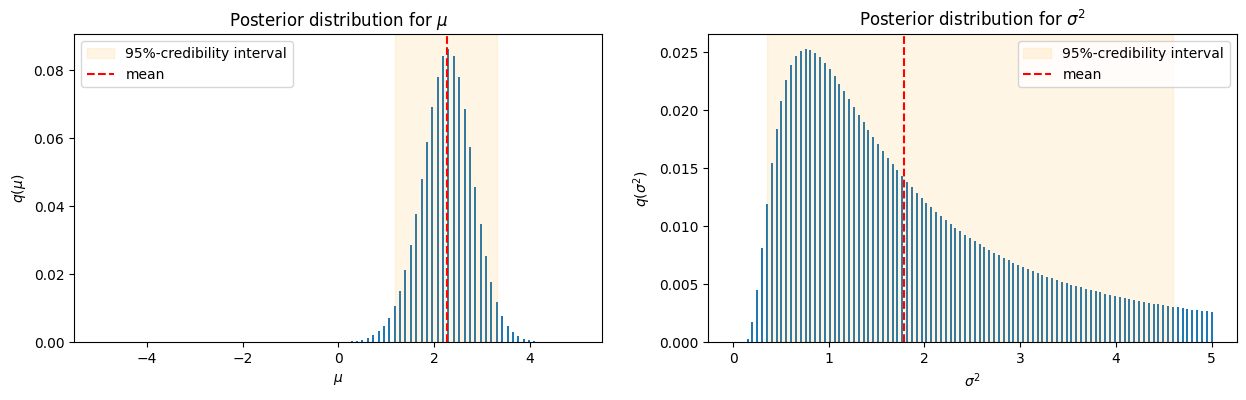

In [62]:
# plot
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
# title
ax[0].set_title('Posterior distribution for $\\mu$')
ax[0].bar(post_approx.alphas, post_approx.pi_alpha, width=0.04)
# Plot the credibility interval in a different color
lower, upper = post_alpha_marginal.central_interval()
ax[0].axvspan(lower, upper, alpha=0.1, color='orange', label='95%-credibility interval')
# plot mean
ax[0].axvline(post_alpha_marginal.mean, color='red', linestyle='--', label='mean')
ax[0].set(xlabel='$\\mu$', ylabel='$q(\\mu)$')


ax[1].set_title('Posterior distribution for $\\sigma^2$')
ax[1].bar(post_approx.betas, post_approx.pi_beta, width=0.02)
# Plot the credibility interval in a different color
lower, upper = post_beta_marginal.central_interval()
ax[1].axvspan(lower, upper, alpha=0.1, color='orange', label='95%-credibility interval')
# plot mean 
ax[1].axvline(post_beta_marginal.mean, color='r', linestyle='--', label='mean')
ax[1].set(xlabel='$\\sigma^2$', ylabel='$q(\\sigma^2)$');

ax[0].legend()
ax[1].legend()

## Task 4.4